# Vanishing Gradient Poblem

Here the vanishing gradient problem effect is visualized by using two activation functions Sigmoid and Relu. 

This project uses MNIST dataset which contains binary images of handwritten digits, thus has class from 0 to 9. 

In [5]:
import torch
from torch import nn
import numpy as np
import copy
import random
import matplotlib.pyplot as plt

from dataset import get_dataset
random.seed(0)

used_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
training_size = 2500 
test_size = 1000  
num_classes = len(used_labels)

# extracting split dataset
x_train, y_train, x_test, y_test, class_names = get_dataset( 'mnist', used_labels, training_size, test_size )

In [6]:
# Normalizing the data

def normalize_data(x_train,x_test):
    x_train_vectors = x_train.reshape((x_train.shape[0], -1))
    mu = np.mean(x_train_vectors, axis=0) # mean of distribution
    sigma = np.std(x_train_vectors) # standard deviation of distribution
    x_train_vectors_normalized = torch.tensor((x_train_vectors-mu)/sigma)

    x_test_vectors = x_test.reshape((x_test.shape[0], -1))
    x_test_vectors_normalized= torch.tensor((x_test_vectors-mu)/sigma)
    x_train =x_train_vectors_normalized
    x_test = x_test_vectors_normalized
    return x_train,x_test

x_train,x_test= normalize_data(x_train,x_test)

We will demonstrate the vanishing gradient problem using models based on mutilayer perceptrons with different number of hidden layers. 

Here we build models with one, two, three and eight hidden layers with 20 hidden neurons. 

In [7]:

class MLP(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,activation,num_lay,):
        super().__init__()
        self.activation = activation 
        self.in_size = input_size 
        self.hidden_size = hidden_size # number of neurons in hidden layer
        self.output_size = output_size 
        self.num_layers = num_lay # number of hidden layers
        self.layers = self.make_layer()
        
        
    def make_layer(self):
        layers = []
        layers.append(nn.Linear(self.in_size,self.hidden_size))
        layers.append(self.activation)
        for i in range(self.num_layers-1):
            layers.append(nn.Linear(self.hidden_size,self.hidden_size))
            layers.append(self.activation)
        layers.append(nn.Linear(self.hidden_size,self.output_size))
        return nn.Sequential(*layers)
            
    def forward(self,inputs):
        return self.layers(inputs)
    
# hidden_neurons = 20
# model1 = MLP(x_train.shape[1],hidden_neurons,num_classes,nn.Sigmoid(),num_lay=8)
# print(model1)

In [8]:
def training_step(train_loader,model,cnt):
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(),lr=0.01)
    temp_loss = []
    for i,(x,y) in enumerate(train_loader):
        x.requires_grad = True
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_function(output,y.long())
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())
    train_loss = np.mean(temp_loss)
    return train_loss

def weights_saver(model,weights_dict):
    cntr = 1
    for idx,param in enumerate(model.named_parameters()):
        if idx%2 == 0:
            key = "layer"+str(cntr)
            if key not in weights_dict:
                weights_dict[key] = []
            weights_dict[key].append(param[1][1].clone())
            cntr +=1
    return weights_dict
            

def testing(model,test_loader):
    total_preds, true_preds = 0,0
    temp_loss = []
    loss_function = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for indx,(x,y) in enumerate(test_loader):
            output = model(x)
            loss = loss_function(output, y.long())
            temp_loss.append(loss.item())
            _,predicted = torch.max(output.data,1)
            total_preds += y.shape[0]
            true_preds += torch.sum(predicted == y).item()
        testing_loss = np.mean(temp_loss)
    accuracy = (true_preds/total_preds)*100
    return accuracy,testing_loss


def main(epoches,models,train_loader,test_loader):
    
    model_weights_epoch = []
    for idx, model in enumerate(models):
        print (f"------------Model{idx+1}------------")

        initial_weights = {}
        saved_weights  = weights_saver(model,initial_weights)
        for i in range(epoches):
            model.train()
            mean_loss = training_step(train_loader,model,idx)
            saved_weights  = weights_saver(model,saved_weights)
           
            if i%10 == 0:
                print(f"Epoch : {i}, train_loss: {mean_loss}")
                
        model_weights_epoch.append(saved_weights)
        accuracy,testing_loss = testing(model,test_loader)
        print(f"Testing_accuracy : {accuracy}")
    return model_weights_epoch

epoches = 51
hidden_neurons = 20
lr_rate = 0.01

# models with Sigmoid activation function
model1 = MLP(x_train.shape[1],hidden_neurons,num_classes,nn.Sigmoid(),num_lay=1) #model with 1 hidden layers
model2 =MLP(x_train.shape[1],hidden_neurons,num_classes,nn.Sigmoid(),num_lay=2)  #model wiht 2 hidden layers
model3 = MLP(x_train.shape[1],hidden_neurons,num_classes,nn.Sigmoid(),num_lay=3) #model with 3 hidden layers
model4 = MLP(x_train.shape[1],hidden_neurons,num_classes,nn.Sigmoid(),num_lay=8) #model wiht 8 hidden layers

train_dataset = [[x_train[indx],y_train[indx]]for indx,i in enumerate(x_train)]
test_dataset = [[x_test[indx],y_test[indx]]for indx,i in enumerate(x_test)]

train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=16)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=16)

models = [model1,model2,model3,model4]

grad_epoch = main(epoches,models,train_loader,test_loader)
gradients_sig_1 = grad_epoch[0]
gradients_sig_2= grad_epoch[1]
gradients_sig_3 = grad_epoch[2]
gradients_sig_4 = grad_epoch[3]

------------Model1------------
Epoch : 0, train_loss: 1.0431511267185212
Epoch : 10, train_loss: 0.21887105200737714
Epoch : 20, train_loss: 0.17752122366651893
Epoch : 30, train_loss: 0.1554284688917299
Epoch : 40, train_loss: 0.14059735620723415
Epoch : 50, train_loss: 0.12963010561056434
Testing_accuracy : 94.44
------------Model2------------
Epoch : 0, train_loss: 2.1078636737505594
Epoch : 10, train_loss: 0.2781265157431364
Epoch : 20, train_loss: 0.1980476268596947
Epoch : 30, train_loss: 0.1619193300085763
Epoch : 40, train_loss: 0.13976629329609375
Epoch : 50, train_loss: 0.12411886325118443
Testing_accuracy : 94.47
------------Model3------------
Epoch : 0, train_loss: 2.3003711570739744
Epoch : 10, train_loss: 0.5991332490722339
Epoch : 20, train_loss: 0.2870525063912074
Epoch : 30, train_loss: 0.2116541013022264
Epoch : 40, train_loss: 0.1750958846276005
Epoch : 50, train_loss: 0.15130315685768922
Testing_accuracy : 93.28
------------Model4------------
Epoch : 0, train_loss: 

In [9]:
# calculates difference of weights between epochs and stores gradients
gradients_sig_models = [gradients_sig_1,gradients_sig_2,gradients_sig_3,gradients_sig_4]
for model in gradients_sig_models:
    layers_list = [keys for keys in model.keys()]
    for layer in layers_list:
        model[layer]= np.array([[float(torch.mean(torch.abs((model[layer][i+1]-model[layer][i])/lr_rate))),\
                        float(torch.std(torch.abs((model[layer][i+1]-model[layer][i])/lr_rate)))] \
                       for i in range(len(model[layer])-1)])

In [10]:
epoches = 51
hidden_neurons = 20

# Models with Relu activation function
relu_model1 = MLP(x_train.shape[1],hidden_neurons,num_classes,nn.ReLU(),num_lay=1) #model with 1 hidden layers
relu_model2 = MLP(x_train.shape[1],hidden_neurons,num_classes,nn.ReLU(),num_lay=2) #model with 2 hidden layers
relu_model3 = MLP(x_train.shape[1],hidden_neurons,num_classes,nn.ReLU(),num_lay=3) #model with 3 hidden layers
relu_model4 = MLP(x_train.shape[1],hidden_neurons,num_classes,nn.ReLU(),num_lay=8) #model with 8 hidden layers

train_dataset = [[x_train[indx],y_train[indx]]for indx,i in enumerate(x_train)]
test_dataset = [[x_test[indx],y_test[indx]]for indx,i in enumerate(x_test)]

train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=16)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=16)

models = [relu_model1,relu_model2,relu_model3,relu_model4]

grad_epoch = main(epoches,models,train_loader,test_loader)

gradients_relu_1 = grad_epoch[0]
gradients_relu_2= grad_epoch[1]
gradients_relu_3 = grad_epoch[2]
gradients_relu_4 = grad_epoch[3]

gradients_relu_models = [gradients_relu_1,gradients_relu_2,gradients_relu_3,gradients_relu_4]

for model in gradients_relu_models:
    layers_list = [keys for keys in model.keys()]
    for layer in layers_list:
         model[layer]= np.array([[float(torch.mean(torch.abs((model[layer][i+1]-model[layer][i])/lr_rate))),\
                        float(torch.std(torch.abs((model[layer][i+1]-model[layer][i])/lr_rate)))] \
                       for i in range(len(model[layer])-1)])
        

------------Model1------------
Epoch : 0, train_loss: 0.39709545400639373
Epoch : 10, train_loss: 0.10923345933717986
Epoch : 20, train_loss: 0.08361313719536023
Epoch : 30, train_loss: 0.06944687739122891
Epoch : 40, train_loss: 0.059584705263971895
Epoch : 50, train_loss: 0.051486129542578904
Testing_accuracy : 95.83
------------Model2------------
Epoch : 0, train_loss: 0.5384764273218811
Epoch : 10, train_loss: 0.09265465309006783
Epoch : 20, train_loss: 0.06571224294381488
Epoch : 30, train_loss: 0.05028880130065712
Epoch : 40, train_loss: 0.04007395024085539
Epoch : 50, train_loss: 0.03293546894890787
Testing_accuracy : 95.97
------------Model3------------
Epoch : 0, train_loss: 0.7869079247772693
Epoch : 10, train_loss: 0.10289019626515607
Epoch : 20, train_loss: 0.07115142148901553
Epoch : 30, train_loss: 0.05530981064705217
Epoch : 40, train_loss: 0.04574013533206271
Epoch : 50, train_loss: 0.040347256854979544
Testing_accuracy : 95.78999999999999
------------Model4------------

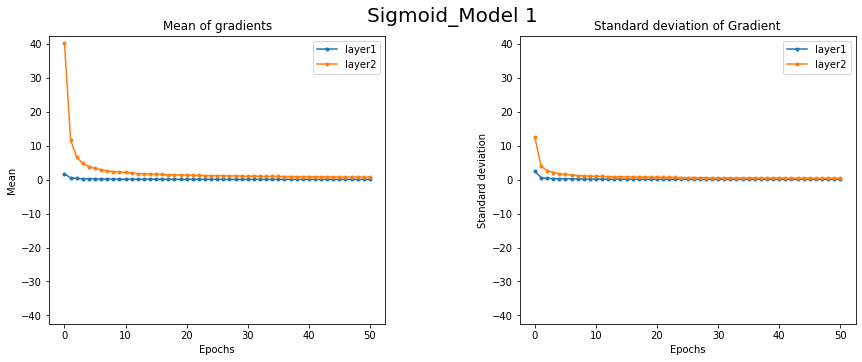

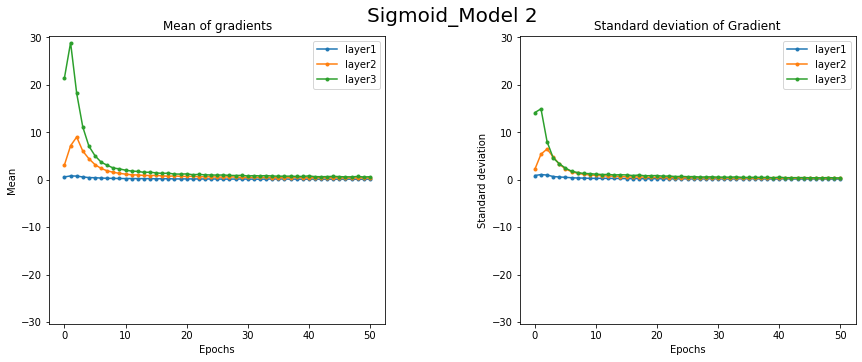

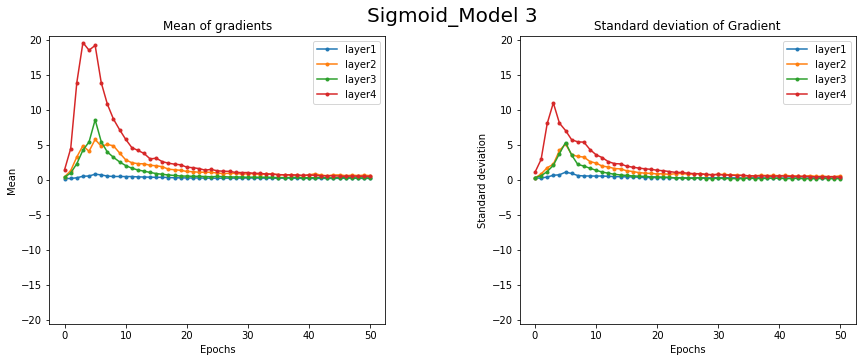

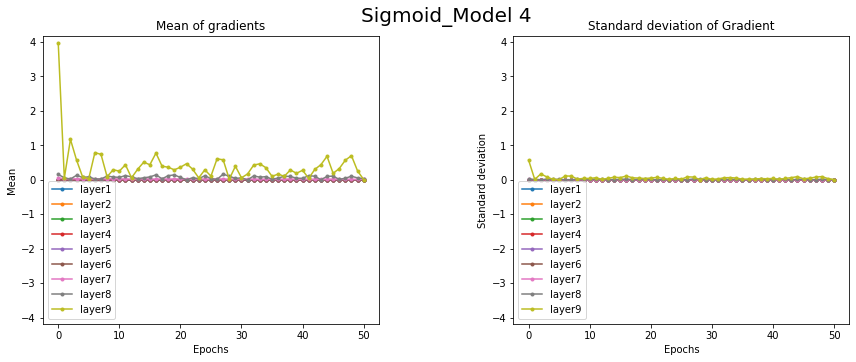

In [11]:
# plots the gradients of each model using sigmoid activation
for indx,model in enumerate(gradients_sig_models):
    layers_list = [keys for keys in model.keys()]
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
    plt.suptitle("Sigmoid_Model "+str(indx+1),fontsize=20)
    for layer in layers_list:
        x = np.arange(len(model[layer]))
        ax1.plot(x,model[layer][:,0],label =layer,marker =".")
        ax1.set_title("Mean of gradients")
        ax1.set(xlabel="Epochs", ylabel="Mean")
        ax1.legend()
        
        ax2.plot(x,model[layer][:,1],label =layer,marker =".")
        ax2.set_title("Standard deviation of Gradient")
        ax2.set(xlabel="Epochs", ylabel="Standard deviation")
        ax2.legend()
        
    yabs_max_ax1 = abs(max(ax1.get_ylim(), key=abs))
    ax1.set_ylim(ymin=-yabs_max_ax1, ymax=yabs_max_ax1)
    yabs_max_ax2 = abs(max(ax1.get_ylim(), key=abs))
    ax2.set_ylim(ymin=-yabs_max_ax2, ymax=yabs_max_ax2)
    
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)
    plt.savefig("./results/Sigmoid_Model_"+str(indx+1)+".png")
    plt.show()


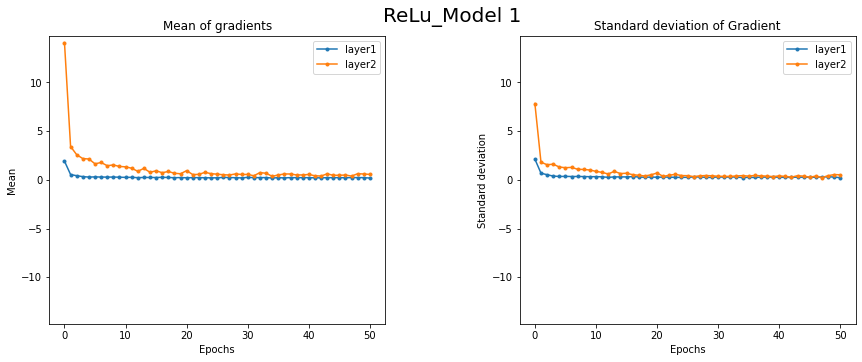

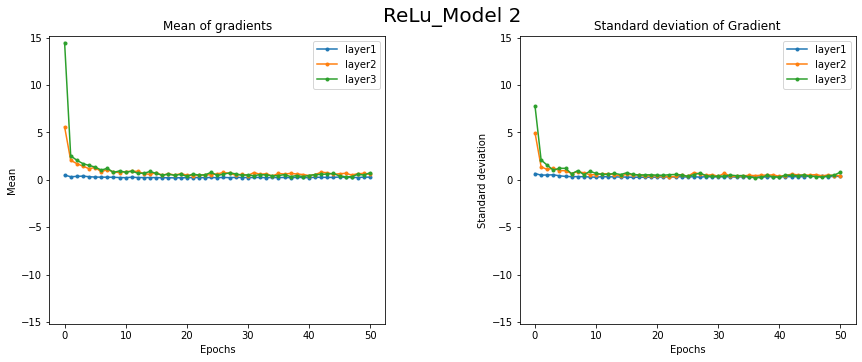

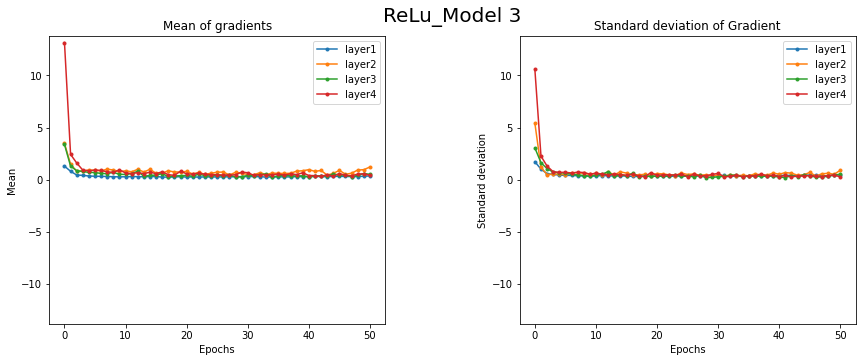

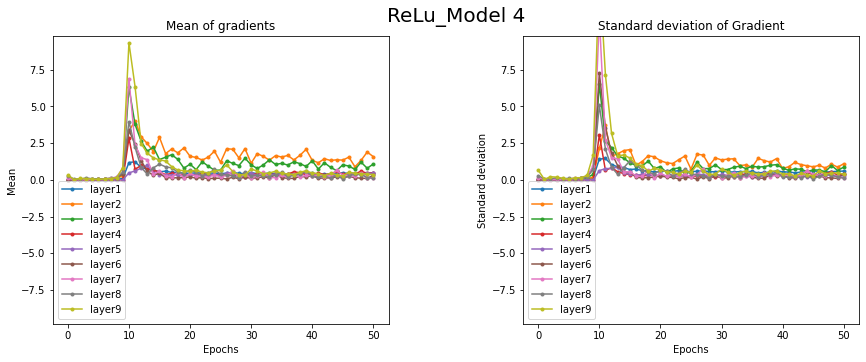

In [12]:
# plots the gradients of each model using Relu activation
for indx,model in enumerate(gradients_relu_models):
    layers_list = [keys for keys in model.keys()]
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
    plt.suptitle("ReLu_Model "+str(indx+1),fontsize=20)
    for layer in layers_list:
        x = np.arange(len(model[layer]))
        ax1.plot(x,model[layer][:,0],label =layer,marker =".")
        ax1.set_title("Mean of gradients")
        ax1.set(xlabel="Epochs", ylabel="Mean")
        ax1.legend()
        ax2.plot(x,model[layer][:,1],label =layer,marker =".")
        ax2.set_title("Standard deviation of Gradient")
        ax2.set(xlabel="Epochs", ylabel="Standard deviation")
        ax2.legend()
        
    yabs_max_ax1 = abs(max(ax1.get_ylim(), key=abs))
    ax1.set_ylim(ymin=-yabs_max_ax1, ymax=yabs_max_ax1)
    yabs_max_ax2 = abs(max(ax1.get_ylim(), key=abs))
    ax2.set_ylim(ymin=-yabs_max_ax2, ymax=yabs_max_ax2)
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)
    plt.savefig("./results/Relu_Model_"+str(indx+1)+".png")
    plt.show()
